In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config import google_api_key
import json
import requests
import sqlite3
from sqlalchemy import create_engine
from numpy.random import choice
from sklearn.impute import SimpleImputer, MissingIndicator
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import f1_score, fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
# Load dataset
# engine = create_engine('sqlite:///../data/lender_data1.db')
# df = pd.read_sql_table('Lender', con=engine)

df = pd.read_csv("temp/lender_checkpoint_1.csv")

# Columns of interest
columns = ['Lender ID', 'City', 'State', 'Multifamily Subtype', 
           'Built', 'Units', 'Original Loan', 'Note Rate', 
           'Loan Term (Original)', 'Appraised Value']
df = df[columns]
df.head()

,Lender ID,City,State,Multifamily Subtype,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value
0,19.0,Costa Mesa,CA,Garden,1990,24.0,"1,720,000",5.8%,180.0,"3,500,000"
1,19.0,Los Angeles,CA,Garden,1962,15.0,"500,000",5.3%,180.0,"1,525,000"
2,50.0,New Orleans,LA,Garden,2009,164.0,"250,000",6.9%,120.0,"4,187,586"
3,19.0,West Hollywood,CA,Garden,1957,11.0,"805,000",5.2%,180.0,"2,450,000"
4,51.0,Brooklyn,NY,Garden,2002,13.0,"1,600,000",6.5%,120.0,"3,112,000"


## 2. Prepare dataset for machine learning

### 2.1. Extract spatial information from `City` and `State`

Note that the machine learning library `sklearn` is only able to work with numerical values. City and State columns are categorical variables with many categories. It's possible to binarize each individual location into a dummy varialble, but this is not efficient and will result in a very sparse table. Even though there is no straightforward ordinal relationships among these locations, it would still be useful to characterize the spatial proximity of the different locations, because certain lenders may dominate certain locations. To do so, I'm going to use city and state as input and convert to latitude and longitude using [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro). The new columns `lat` and `lng` will be used as numerical representation of `City` and `State` in the machine learning model.

In [3]:
# Create a list of unique address to look up
df['address'] = df['City'] + ', ' + df['State']
unique_address_list = df['address'].unique().tolist()
print(f"There are {len(unique_address_list)} unique addresses to be converted to lat and long.")

There are 3705 unique addresses to be converted to lat and long.


In [4]:
# Construct API query
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
params = {"key": google_api_key}

In [24]:
# results_list = []
# for index, address in enumerate(unique_address_list):
    
#     params['address'] = address
#     print(f"Retrieving Results for Index {index}: {address}.")

#     response = requests.get(base_url, params=params).json()
#     results = response.get('results')
#     results_list.append(results)

Retrieving Results for Index 0: Costa Mesa, CA.
Retrieving Results for Index 1: Los Angeles, CA.
Retrieving Results for Index 2: New Orleans, LA.
Retrieving Results for Index 3: West Hollywood, CA.
Retrieving Results for Index 4: Brooklyn, NY.
Retrieving Results for Index 5: Lenexa, KS.
Retrieving Results for Index 6: El Segundo, CA.
Retrieving Results for Index 7: Watertown, NY.
Retrieving Results for Index 8: San Jose, CA.
Retrieving Results for Index 9: Ellaville, GA.
Retrieving Results for Index 10: Hollywood, CA.
Retrieving Results for Index 11: Lynwood, CA.
Retrieving Results for Index 12: Wrightsville, GA.
Retrieving Results for Index 13: Adrian, GA.
Retrieving Results for Index 14: Glendale, CA.
Retrieving Results for Index 15: Glenwood, GA.
Retrieving Results for Index 16: Alamo, GA.
Retrieving Results for Index 17: Preston, GA.
Retrieving Results for Index 18: Norwood, MA.
Retrieving Results for Index 19: Unadilla, GA.
Retrieving Results for Index 20: Gibson, GA.
Retrieving R

Retrieving Results for Index 171: Chula Vista, CA.
Retrieving Results for Index 172: Huntington Park, CA.
Retrieving Results for Index 173: Colorado Springs, CO.
Retrieving Results for Index 174: San Carlos, CA.
Retrieving Results for Index 175: Altadena, CA.
Retrieving Results for Index 176: Salt Lake City, UT.
Retrieving Results for Index 177: Seattle, WA.
Retrieving Results for Index 178: Indian Springs Village, AL.
Retrieving Results for Index 179: Alamogordo, NM.
Retrieving Results for Index 180: Evanston, IL.
Retrieving Results for Index 181: Jerome, ID.
Retrieving Results for Index 182: Woodland Hills, CA.
Retrieving Results for Index 183: Rosemead, CA.
Retrieving Results for Index 184: Hubbard, TX.
Retrieving Results for Index 185: Quincy, MA.
Retrieving Results for Index 186: Wakarusa, IN.
Retrieving Results for Index 187: Coronado, CA.
Retrieving Results for Index 188: Grants Pass, OR.
Retrieving Results for Index 189: West Memphis, AR.
Retrieving Results for Index 190: Lodi,

Retrieving Results for Index 338: LIC, NY.
Retrieving Results for Index 339: YPG, AZ.
Retrieving Results for Index 340: Jackson, MI.
Retrieving Results for Index 341: Hammond, LA.
Retrieving Results for Index 342: Fall River, MA.
Retrieving Results for Index 343: Ashford, CT.
Retrieving Results for Index 344: Cleveland, TX.
Retrieving Results for Index 345: The Bronx, NY.
Retrieving Results for Index 346: Myrtle Beach, SC.
Retrieving Results for Index 347: Lancaster, CA.
Retrieving Results for Index 348: Lexington, SC.
Retrieving Results for Index 349: Pine Lake, GA.
Retrieving Results for Index 350: Hagerstown, MD.
Retrieving Results for Index 351: WARRENSVL HTS, OH.
Retrieving Results for Index 352: Bladensburg, MD.
Retrieving Results for Index 353: Powdersville, SC.
Retrieving Results for Index 354: Kent, WA.
Retrieving Results for Index 355: Springdale, AR.
Retrieving Results for Index 356: Casper, WY.
Retrieving Results for Index 357: Huntington Beach, CA.
Retrieving Results for I

Retrieving Results for Index 506: Uniontown, PA.
Retrieving Results for Index 507: Los Gatos, CA.
Retrieving Results for Index 508: Geneva, NY.
Retrieving Results for Index 509: Royal Oak, MI.
Retrieving Results for Index 510: Anderson, SC.
Retrieving Results for Index 511: Starkville, MS.
Retrieving Results for Index 512: Davenport, IA.
Retrieving Results for Index 513: Hollywood, FL.
Retrieving Results for Index 514: Canyon, TX.
Retrieving Results for Index 515: Gonzales, TX.
Retrieving Results for Index 516: DW GDNS, TX.
Retrieving Results for Index 517: MIDDLE CITY WEST, PA.
Retrieving Results for Index 518: Harlingen, TX.
Retrieving Results for Index 519: Eureka, CA.
Retrieving Results for Index 520: Clayton, GA.
Retrieving Results for Index 521: Asheville, NC.
Retrieving Results for Index 522: Clinton Twp, MI.
Retrieving Results for Index 523: North Charleston, SC.
Retrieving Results for Index 524: Concord, CA.
Retrieving Results for Index 525: Durant, OK.
Retrieving Results for 

Retrieving Results for Index 674: Boca Raton, FL.
Retrieving Results for Index 675: Portsmouth, VA.
Retrieving Results for Index 676: Everett, MA.
Retrieving Results for Index 677: Scarsdale, NY.
Retrieving Results for Index 678: Rexburg, ID.
Retrieving Results for Index 679: Bradenton, FL.
Retrieving Results for Index 680: Tujunga, CA.
Retrieving Results for Index 681: Vallejo, CA.
Retrieving Results for Index 682: Sebring, OH.
Retrieving Results for Index 683: Euharlee, GA.
Retrieving Results for Index 684: Madison, WI.
Retrieving Results for Index 685: North Bergen, NJ.
Retrieving Results for Index 686: Greeley, CO.
Retrieving Results for Index 687: Meridian, MS.
Retrieving Results for Index 688: Norwood Young America, MN.
Retrieving Results for Index 689: North Chesterfield, VA.
Retrieving Results for Index 690: Duluth, MN.
Retrieving Results for Index 691: Fort Atkinson, WI.
Retrieving Results for Index 692: Elgin, IL.
Retrieving Results for Index 693: Hobbs, NM.
Retrieving Result

Retrieving Results for Index 842: Kingston, NY.
Retrieving Results for Index 843: Valrico, FL.
Retrieving Results for Index 844: Hemet, CA.
Retrieving Results for Index 845: Ocala, FL.
Retrieving Results for Index 846: Ferndale, WA.
Retrieving Results for Index 847: Batesburg-Leesville, SC.
Retrieving Results for Index 848: Upland, CA.
Retrieving Results for Index 849: Dothan, AL.
Retrieving Results for Index 850: Des Plaines, IL.
Retrieving Results for Index 851: Painesville, OH.
Retrieving Results for Index 852: TN OF TONA, NY.
Retrieving Results for Index 853: Seneca, SC.
Retrieving Results for Index 854: Windsor Locks, CT.
Retrieving Results for Index 855: Wyandanch, NY.
Retrieving Results for Index 856: Savage, MN.
Retrieving Results for Index 857: Manhattan, KS.
Retrieving Results for Index 858: NEW SALEM BRO, PA.
Retrieving Results for Index 859: Modesto, CA.
Retrieving Results for Index 860: Lehman Township, PA.
Retrieving Results for Index 861: Franklin Park, IL.
Retrieving Re

Retrieving Results for Index 1009: Los Nietos, CA.
Retrieving Results for Index 1010: Kinston, NC.
Retrieving Results for Index 1011: Getzville, NY.
Retrieving Results for Index 1012: Fort Pierce, FL.
Retrieving Results for Index 1013: Victoria, TX.
Retrieving Results for Index 1014: Calumet Park, IL.
Retrieving Results for Index 1015: South Corning, NY.
Retrieving Results for Index 1016: Garrison, MD.
Retrieving Results for Index 1017: Blaine, MN.
Retrieving Results for Index 1018: Lisle, NY.
Retrieving Results for Index 1019: Omaha, NE.
Retrieving Results for Index 1020: N MARTINSVLLE, WV.
Retrieving Results for Index 1021: Columbus, GA.
Retrieving Results for Index 1022: Easley, SC.
Retrieving Results for Index 1023: Lexington, KY.
Retrieving Results for Index 1024: Poughkeepsie, NY.
Retrieving Results for Index 1025: Hot Springs National Park, AR.
Retrieving Results for Index 1026: HVRE DE GRACE, MD.
Retrieving Results for Index 1027: Corinth, NY.
Retrieving Results for Index 1028:

Retrieving Results for Index 1174: Auburn, WA.
Retrieving Results for Index 1175: Lower Merion Township, PA.
Retrieving Results for Index 1176: Berkeley, CA.
Retrieving Results for Index 1177: Midvale, UT.
Retrieving Results for Index 1178: Heeney, CO.
Retrieving Results for Index 1179: Medora, KS.
Retrieving Results for Index 1180: Wadsworth, NV.
Retrieving Results for Index 1181: Tewksbury, MA.
Retrieving Results for Index 1182: Burlington, CO.
Retrieving Results for Index 1183: Tullahoma, TN.
Retrieving Results for Index 1184: Wichita Falls, TX.
Retrieving Results for Index 1185: Bixby, OK.
Retrieving Results for Index 1186: De Soto, MO.
Retrieving Results for Index 1187: Las Vegas, NV.
Retrieving Results for Index 1188: Shakopee, MN.
Retrieving Results for Index 1189: Mansfield Center, CT.
Retrieving Results for Index 1190: Lawndale, CA.
Retrieving Results for Index 1191: Columbus, MS.
Retrieving Results for Index 1192: KNG OF PRUSSA, PA.
Retrieving Results for Index 1193: Redding,

Retrieving Results for Index 1337: High Point, NC.
Retrieving Results for Index 1338: Gallup, NM.
Retrieving Results for Index 1339: East Islip, NY.
Retrieving Results for Index 1340: Orange Park, FL.
Retrieving Results for Index 1341: Camarillo, CA.
Retrieving Results for Index 1342: Larkfield-Wikiup, CA.
Retrieving Results for Index 1343: Seymour, IN.
Retrieving Results for Index 1344: Washington, IN.
Retrieving Results for Index 1345: Orangevale, CA.
Retrieving Results for Index 1346: Pinole, CA.
Retrieving Results for Index 1347: VLG LOCH LOYD, MO.
Retrieving Results for Index 1348: Brookline, MA.
Retrieving Results for Index 1349: Parma, OH.
Retrieving Results for Index 1350: Franklin, IN.
Retrieving Results for Index 1351: Athens, GA.
Retrieving Results for Index 1352: Lake Placid, FL.
Retrieving Results for Index 1353: Frisco, TX.
Retrieving Results for Index 1354: South Zanesville, OH.
Retrieving Results for Index 1355: Provo Canyon, UT.
Retrieving Results for Index 1356: Erial

Retrieving Results for Index 1501: Stanton, CA.
Retrieving Results for Index 1502: Bloomington, IN.
Retrieving Results for Index 1503: North Kansas City, MO.
Retrieving Results for Index 1504: Edwardsville, PA.
Retrieving Results for Index 1505: UPPER ARLNGTN, OH.
Retrieving Results for Index 1506: Midland, MI.
Retrieving Results for Index 1507: North Platte, NE.
Retrieving Results for Index 1508: Fuquay-Varina, NC.
Retrieving Results for Index 1509: NAS Point Mugu, CA.
Retrieving Results for Index 1510: Essex, MD.
Retrieving Results for Index 1511: Hoffman, OK.
Retrieving Results for Index 1512: Castle Rock, CO.
Retrieving Results for Index 1513: Dodge City, AL.
Retrieving Results for Index 1514: Waltham, MA.
Retrieving Results for Index 1515: West Los Angeles, CA.
Retrieving Results for Index 1516: Burlington, KY.
Retrieving Results for Index 1517: MAGNOLIA SQUARE, FL.
Retrieving Results for Index 1518: Hudson, WI.
Retrieving Results for Index 1519: Cheyenne, WY.
Retrieving Results f

Retrieving Results for Index 1664: Woburn, MA.
Retrieving Results for Index 1665: Sandston, VA.
Retrieving Results for Index 1666: Lewisburg, WV.
Retrieving Results for Index 1667: Missouri City, TX.
Retrieving Results for Index 1668: Tupelo, MS.
Retrieving Results for Index 1669: Rego Park, NY.
Retrieving Results for Index 1670: Saginaw, MI.
Retrieving Results for Index 1671: Sanford, NC.
Retrieving Results for Index 1672: Carlisle, MN.
Retrieving Results for Index 1673: Sudley Springs, VA.
Retrieving Results for Index 1674: Hurst, TX.
Retrieving Results for Index 1675: Inglewood, NE.
Retrieving Results for Index 1676: Camino, CA.
Retrieving Results for Index 1677: Thomaston, GA.
Retrieving Results for Index 1678: Alta Loma, TX.
Retrieving Results for Index 1679: Kirkville, NY.
Retrieving Results for Index 1680: Sarasota, FL.
Retrieving Results for Index 1681: Junction City, KS.
Retrieving Results for Index 1682: Fort Stewart, GA.
Retrieving Results for Index 1683: Covington, GA.
Retr

Retrieving Results for Index 1828: Sioux City, IA.
Retrieving Results for Index 1829: Cypress Gardens, FL.
Retrieving Results for Index 1830: Marrero, LA.
Retrieving Results for Index 1831: Pendleton, OR.
Retrieving Results for Index 1832: Georgetown, DE.
Retrieving Results for Index 1833: Edgewater, FL.
Retrieving Results for Index 1834: Mosier, OR.
Retrieving Results for Index 1835: Berwyn Heights, MD.
Retrieving Results for Index 1836: Cañon City, CO.
Retrieving Results for Index 1837: Independence, MO.
Retrieving Results for Index 1838: Sun Prairie, WI.
Retrieving Results for Index 1839: Raymore, MO.
Retrieving Results for Index 1840: Oak Creek, WI.
Retrieving Results for Index 1841: Ranson, WV.
Retrieving Results for Index 1842: PT ORANGE, FL.
Retrieving Results for Index 1843: Blair, NE.
Retrieving Results for Index 1844: Shelbyville, IN.
Retrieving Results for Index 1845: Arlington, MA.
Retrieving Results for Index 1846: Leesburg, FL.
Retrieving Results for Index 1847: Laurinbur

Retrieving Results for Index 1991: Aloma, FL.
Retrieving Results for Index 1992: London, OH.
Retrieving Results for Index 1993: Windsor, CO.
Retrieving Results for Index 1994: Harbor Beach, MI.
Retrieving Results for Index 1995: Independence, KY.
Retrieving Results for Index 1996: Sewickley, PA.
Retrieving Results for Index 1997: Saginaw, TX.
Retrieving Results for Index 1998: Troy, OH.
Retrieving Results for Index 1999: GRANDVIEW, OH.
Retrieving Results for Index 2000: Sahuarita, AZ.
Retrieving Results for Index 2001: Monticello, FL.
Retrieving Results for Index 2002: Centerton, AR.
Retrieving Results for Index 2003: Pontiac, IL.
Retrieving Results for Index 2004: Livonia, MI.
Retrieving Results for Index 2005: Findlay, OH.
Retrieving Results for Index 2006: Acton, MA.
Retrieving Results for Index 2007: Hanover, PA.
Retrieving Results for Index 2008: Wyoming, OH.
Retrieving Results for Index 2009: St Regis Park, KY.
Retrieving Results for Index 2010: Horseheads, NY.
Retrieving Results

Retrieving Results for Index 2155: Glen Head, NY.
Retrieving Results for Index 2156: Galveston, TX.
Retrieving Results for Index 2157: Stoughton, WI.
Retrieving Results for Index 2158: South Ogden, UT.
Retrieving Results for Index 2159: Clinton, TN.
Retrieving Results for Index 2160: Croton-On-Hudson, NY.
Retrieving Results for Index 2161: Santa Fe Springs, CA.
Retrieving Results for Index 2162: Gretna, LA.
Retrieving Results for Index 2163: Porter Ranch, CA.
Retrieving Results for Index 2164: Oceanport, NJ.
Retrieving Results for Index 2165: Columbia, PA.
Retrieving Results for Index 2166: Marysville, MI.
Retrieving Results for Index 2167: Castro Valley, CA.
Retrieving Results for Index 2168: CARPENTERSVLE, IL.
Retrieving Results for Index 2169: West Bloomfield Charter Township, MI.
Retrieving Results for Index 2170: Elkhorn, NE.
Retrieving Results for Index 2171: Huber Heights, OH.
Retrieving Results for Index 2172: Henderson, KY.
Retrieving Results for Index 2173: Bemidji, MN.
Retri

Retrieving Results for Index 2318: Valley Grande, AL.
Retrieving Results for Index 2319: Warsaw, IN.
Retrieving Results for Index 2320: Haslett, MI.
Retrieving Results for Index 2321: Lyon Charter Twp, MI.
Retrieving Results for Index 2322: Benton, AR.
Retrieving Results for Index 2323: West Columbia, TX.
Retrieving Results for Index 2324: Walnutport, PA.
Retrieving Results for Index 2325: Dewitt, MI.
Retrieving Results for Index 2326: Brea, CA.
Retrieving Results for Index 2327: Blacksburg, VA.
Retrieving Results for Index 2328: Sheboygan Falls, WI.
Retrieving Results for Index 2329: Browns Summit, NC.
Retrieving Results for Index 2330: Penndel, PA.
Retrieving Results for Index 2331: Northport, NY.
Retrieving Results for Index 2332: Larchmont, NY.
Retrieving Results for Index 2333: COLD SPRGS HI, KY.
Retrieving Results for Index 2334: Milford, DE.
Retrieving Results for Index 2335: Kerman, CA.
Retrieving Results for Index 2336: Lakeside, CA.
Retrieving Results for Index 2337: Slingerl

Retrieving Results for Index 2483: Spring, TX.
Retrieving Results for Index 2484: Clarksville, IN.
Retrieving Results for Index 2485: Ellenton, FL.
Retrieving Results for Index 2486: Ossining, NY.
Retrieving Results for Index 2487: Hartford, WI.
Retrieving Results for Index 2488: FORADA, MN.
Retrieving Results for Index 2489: NEW CARROLLTN, MD.
Retrieving Results for Index 2490: Villa Rica, GA.
Retrieving Results for Index 2491: Minocqua, WI.
Retrieving Results for Index 2492: Greece, NY.
Retrieving Results for Index 2493: Geneseo, NY.
Retrieving Results for Index 2494: Cayce, SC.
Retrieving Results for Index 2495: Boone, NC.
Retrieving Results for Index 2496: Morristown, NJ.
Retrieving Results for Index 2497: Fort Madison, IA.
Retrieving Results for Index 2498: Canyonville, OR.
Retrieving Results for Index 2499: Ellenwood, GA.
Retrieving Results for Index 2500: Centerville, OH.
Retrieving Results for Index 2501: Vernonburg, GA.
Retrieving Results for Index 2502: Newnan, GA.
Retrieving

Retrieving Results for Index 2647: Orosi, CA.
Retrieving Results for Index 2648: Cherry Hill, NJ.
Retrieving Results for Index 2649: Springfield, PA.
Retrieving Results for Index 2650: Westwood, NJ.
Retrieving Results for Index 2651: Anna, IL.
Retrieving Results for Index 2652: Avondale, AZ.
Retrieving Results for Index 2653: Otis Orchards, WA.
Retrieving Results for Index 2654: Fortuna, CA.
Retrieving Results for Index 2655: Sturgeon Bay, WI.
Retrieving Results for Index 2656: Plant City, FL.
Retrieving Results for Index 2657: Watervliet, MI.
Retrieving Results for Index 2658: Middletown, CT.
Retrieving Results for Index 2659: COCKYSVIL, MD.
Retrieving Results for Index 2660: Salem, VA.
Retrieving Results for Index 2661: FSTRVL TRVOSE, PA.
Retrieving Results for Index 2662: Kelso, WA.
Retrieving Results for Index 2663: Essexville, MI.
Retrieving Results for Index 2664: Stanwood, WA.
Retrieving Results for Index 2665: Third Lake, IL.
Retrieving Results for Index 2666: Galesburg, IL.
Re

Retrieving Results for Index 2809: Fairview, OR.
Retrieving Results for Index 2810: Metuchen, NJ.
Retrieving Results for Index 2811: Big Canoe, GA.
Retrieving Results for Index 2812: Norcross, GA.
Retrieving Results for Index 2813: Jamestown, CA.
Retrieving Results for Index 2814: Castroville, TX.
Retrieving Results for Index 2815: Falls Church, VA.
Retrieving Results for Index 2816: Potterville, MI.
Retrieving Results for Index 2817: Homosassa Springs, FL.
Retrieving Results for Index 2818: Linfield, PA.
Retrieving Results for Index 2819: Chesterton, IN.
Retrieving Results for Index 2820: Verona, PA.
Retrieving Results for Index 2821: CONCORD FARR, TN.
Retrieving Results for Index 2822: Lyman, ME.
Retrieving Results for Index 2823: Canton, GA.
Retrieving Results for Index 2824: Hiram, OH.
Retrieving Results for Index 2825: Altamonte Springs, FL.
Retrieving Results for Index 2826: Kirkland, WA.
Retrieving Results for Index 2827: Melrose, TN.
Retrieving Results for Index 2828: Riverton,

Retrieving Results for Index 2972: Hyattsville, MD.
Retrieving Results for Index 2973: Wayland, MI.
Retrieving Results for Index 2974: Guadalupe, CA.
Retrieving Results for Index 2975: Monmouth, OR.
Retrieving Results for Index 2976: Kronenwetter, WI.
Retrieving Results for Index 2977: East Providence, RI.
Retrieving Results for Index 2978: Lenoir City, TN.
Retrieving Results for Index 2979: Roselle Park, NJ.
Retrieving Results for Index 2980: Selma, CA.
Retrieving Results for Index 2981: Wilmette, IL.
Retrieving Results for Index 2982: Pearland, TX.
Retrieving Results for Index 2983: Library, PA.
Retrieving Results for Index 2984: Horn Lake, MS.
Retrieving Results for Index 2985: Big Rapids, MI.
Retrieving Results for Index 2986: Spring City, PA.
Retrieving Results for Index 2987: Granger, IN.
Retrieving Results for Index 2988: Floresville, TX.
Retrieving Results for Index 2989: Spring Park, MN.
Retrieving Results for Index 2990: Delray Beach, FL.
Retrieving Results for Index 2991: So

Retrieving Results for Index 3134: NO FORT MYERS, FL.
Retrieving Results for Index 3135: Williamsport, MD.
Retrieving Results for Index 3136: Sunbury, OH.
Retrieving Results for Index 3137: Lake Forest, CA.
Retrieving Results for Index 3138: Bargersville, IN.
Retrieving Results for Index 3139: Phillips Ranch, CA.
Retrieving Results for Index 3140: Red Lion, PA.
Retrieving Results for Index 3141: Owasco, NY.
Retrieving Results for Index 3142: Glen Ellyn, IL.
Retrieving Results for Index 3143: Muscle Shoals, AL.
Retrieving Results for Index 3144: New Windsor, NY.
Retrieving Results for Index 3145: Bethel Park, PA.
Retrieving Results for Index 3146: New City, NY.
Retrieving Results for Index 3147: Pennsville, NJ.
Retrieving Results for Index 3148: Sanatoga, PA.
Retrieving Results for Index 3149: Duvall, WA.
Retrieving Results for Index 3150: Culloden, WV.
Retrieving Results for Index 3151: Nashua, NH.
Retrieving Results for Index 3152: Salina, KS.
Retrieving Results for Index 3153: Ingles

Retrieving Results for Index 3297: Cypress, TX.
Retrieving Results for Index 3298: Mechanicsburg, PA.
Retrieving Results for Index 3299: Harrington, DE.
Retrieving Results for Index 3300: Toms River, NJ.
Retrieving Results for Index 3301: Hunter AAF, GA.
Retrieving Results for Index 3302: Wyandotte, MI.
Retrieving Results for Index 3303: Hermon, ME.
Retrieving Results for Index 3304: HALNDLE BCH, FL.
Retrieving Results for Index 3305: Mastic Beach, NY.
Retrieving Results for Index 3306: San Bruno, CA.
Retrieving Results for Index 3307: Beeville, TX.
Retrieving Results for Index 3308: CASTLETON, NY.
Retrieving Results for Index 3309: Big Spring, KY.
Retrieving Results for Index 3310: Lansdowne, VA.
Retrieving Results for Index 3311: BVL, FL.
Retrieving Results for Index 3312: Helotes, TX.
Retrieving Results for Index 3313: Clodine, TX.
Retrieving Results for Index 3314: Sharon Hill, PA.
Retrieving Results for Index 3315: Riverdale, IA.
Retrieving Results for Index 3316: Robinsonville, M

Retrieving Results for Index 3460: New Lenox, IL.
Retrieving Results for Index 3461: Shrewsbury, MA.
Retrieving Results for Index 3462: Kathleen, GA.
Retrieving Results for Index 3463: Chino Hills, CA.
Retrieving Results for Index 3464: Windsor, CT.
Retrieving Results for Index 3465: Malvern, PA.
Retrieving Results for Index 3466: Port Acres, TX.
Retrieving Results for Index 3467: ROWLAND HGHTS, CA.
Retrieving Results for Index 3468: Allen, TX.
Retrieving Results for Index 3469: East Brunswick, NJ.
Retrieving Results for Index 3470: Mansfield, TX.
Retrieving Results for Index 3471: Farmington, CT.
Retrieving Results for Index 3472: Selden, NY.
Retrieving Results for Index 3473: Paducah, KY.
Retrieving Results for Index 3474: Lakehurst, NJ.
Retrieving Results for Index 3475: Weldon Spring, MO.
Retrieving Results for Index 3476: North Smithfield, RI.
Retrieving Results for Index 3477: Creedmoor, TX.
Retrieving Results for Index 3478: Cypress, CA.
Retrieving Results for Index 3479: Romeov

Retrieving Results for Index 3622: Cornelius, NC.
Retrieving Results for Index 3623: Lake Shore, MD.
Retrieving Results for Index 3624: Ellicott City, MD.
Retrieving Results for Index 3625: Rancho Santa Margarita, CA.
Retrieving Results for Index 3626: Annandale, NJ.
Retrieving Results for Index 3627: Franklin Center, PA.
Retrieving Results for Index 3628: Hicksville, NY.
Retrieving Results for Index 3629: UPR MARLBORO, MD.
Retrieving Results for Index 3630: Yulee, FL.
Retrieving Results for Index 3631: Cardiff, CA.
Retrieving Results for Index 3632: Abington, MA.
Retrieving Results for Index 3633: Dover, NJ.
Retrieving Results for Index 3634: Hillsboro Beach, FL.
Retrieving Results for Index 3635: Portola Hills, CA.
Retrieving Results for Index 3636: North Massapequa, NY.
Retrieving Results for Index 3637: Leesburg, VA.
Retrieving Results for Index 3638: Jurupa Valley, CA.
Retrieving Results for Index 3639: Pike Rd, AL.
Retrieving Results for Index 3640: Blawnox, PA.
Retrieving Result

In [25]:
# # Save results from API requests
# with open('temp/address_latlng.json', 'w') as file_out:
#     json.dump(results_list, file_out)

In [5]:
# Load results from API requests
with open('temp/address_latlng.json', 'r') as file_in:
    address_latlng = json.load(file_in)

In [6]:
# Example API results
address_latlng[0]

[{'address_components': [{'long_name': 'Costa Mesa',
    'short_name': 'Costa Mesa',
    'types': ['locality', 'political']},
   {'long_name': 'Orange County',
    'short_name': 'Orange County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'California',
    'short_name': 'CA',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']}],
  'formatted_address': 'Costa Mesa, CA, USA',
  'geometry': {'bounds': {'northeast': {'lat': 33.7020933,
     'lng': -117.8639744},
    'southwest': {'lat': 33.6251229, 'lng': -117.9547143}},
   'location': {'lat': 33.6412156, 'lng': -117.9188221},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 33.7020933, 'lng': -117.8639744},
    'southwest': {'lat': 33.6251229, 'lng': -117.9547143}}},
  'place_id': 'ChIJeW9X_G_f3IAR2sAD2BKEAe8',
  'types': ['locality', 'political']}]

In [7]:
# Define a function to retrieve lat and long information from API results of a particular address
def retrieve_lat_lng(index, results, address_unique=unique_address_list):
    '''
    Retrieve latitude and longitude information from API results
    INPUTS:
        index (int) - index of the particular address in `unique_address_list`
        results (list) - list of API results of the particular address
        address_unique (list) - list of unique address city, state in the dataframe
    OUTPUTS:
        lat (str or NaN) - latitude of the address
        lng (str or NaN) - longitude of the address
    '''
    lat = np.nan
    lng = np.nan
    
    if (results):
        location = results[0]["geometry"]["location"]
        lat = location.get('lat', '')
        lng = location.get('lng', '')
    else:
        print(f"No results for Index {index}: {address_unique[index]}")
        
    return lat, lng

In [9]:
# Retrieve latitude and longitude information from API results
lat_list = []
lng_list = []

for index, results in enumerate(address_latlng):
    lat, lng = retrieve_lat_lng(index, results)
    lat_list.append(lat)
    lng_list.append(lng)

In [10]:
# Combine location info into dictionary for easy query
address_dict = {}
for index, address in enumerate(unique_address_list):
    address_dict[address] = {'lat': lat_list[index], 'lng': lng_list[index]}

In [11]:
# Fill in lat and long info based on zip code
df['lat'] = df['address'].apply(lambda x: address_dict[x]['lat'])
df['lng'] = df['address'].apply(lambda x: address_dict[x]['lng'])
df.head()

,Lender ID,City,State,Multifamily Subtype,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,address,lat,lng
0,19.0,Costa Mesa,CA,Garden,1990,24.0,"1,720,000",5.8%,180.0,"3,500,000","Costa Mesa, CA",33.641216,-117.918822
1,19.0,Los Angeles,CA,Garden,1962,15.0,"500,000",5.3%,180.0,"1,525,000","Los Angeles, CA",34.052234,-118.243685
2,50.0,New Orleans,LA,Garden,2009,164.0,"250,000",6.9%,120.0,"4,187,586","New Orleans, LA",29.951066,-90.071532
3,19.0,West Hollywood,CA,Garden,1957,11.0,"805,000",5.2%,180.0,"2,450,000","West Hollywood, CA",34.090009,-118.361744
4,51.0,Brooklyn,NY,Garden,2002,13.0,"1,600,000",6.5%,120.0,"3,112,000","Brooklyn, NY",40.678178,-73.944158


In [12]:
# Save as a checkpoint
df.to_csv("temp/lender_checkpoint_21.csv", index=False)

### 2.2. Data cleaning

In [2]:
df = pd.read_csv("temp/lender_checkpoint_21.csv")
df.dtypes

Lender ID               float64
City                     object
State                    object
Multifamily Subtype      object
Built                    object
Units                   float64
Original Loan            object
Note Rate                object
Loan Term (Original)    float64
Appraised Value          object
address                  object
lat                     float64
lng                     float64
dtype: object

In [3]:
# Drop un-needed columns
df = df.drop(columns=['City', 'State', 'address'])

#### Lender ID

In [4]:
df['Lender ID'] = df['Lender ID'].astype(int)

#### Year Built

In [5]:
# Year built
print("Possible values of the year built variable:")
df['Built'].unique()

Possible values of the year built variable:


array(['1990', '1962', '2009', '1957', '2002', '1996', '1989', '1982',
       '1985', '1955', '1992', '1994', '1986', '1971', '1991', '1979',
       '1978', '1975', '1928', '1900', '1984', '1981', '2014', '1905',
       '1950', '1995', '1942', '1961', '1925', '1959', '2005', '1960',
       '1945', '1885', '1964', '1988', '2000', '1965', '1948', '1912',
       '1963', '1923', '1951', '1999', '1952', '1915', '1976', '1953',
       '2007', '1969', '2008', '1967', '1940', '1958', '1924', '1904',
       '1970', '1927', '1968', '2010', '1941', '2004', '1987', '2006',
       '1920', '1929', '2003', '1907', '1917', '2001', '1906', '1936',
       '1908', '2012', '1954', '2015', '1977', '1997', '1956', '1937',
       '1966', '1931', '1973', '1974', '1930', '1922', '1914', '2011',
       '1972', '1910', '1926', '1921', '1998', '1980', '1877', '1983',
       '1899', '1880', '1909', '1911', '1947', '1883', '1892', '1949',
       '1890', '1888', '1932', '1893', '1919', '1895', '1913', '1891',
      

In [6]:
# Convert to numeric, consider "Various" as NaN
df['Built'] = pd.to_numeric(df['Built'], errors='coerce')

#### Note Rate

In [7]:
# Convert to numeric
df['Note Rate'] = pd.to_numeric(df['Note Rate'].str.strip("%"))

#### Original Loan and Appraised Value

In [8]:
# Convert to numeric
df['Original Loan'] = pd.to_numeric(df['Original Loan'].str.replace(",", ""))
df['Appraised Value'] = pd.to_numeric(df['Appraised Value'].str.replace(",", ""))

In [9]:
# Sanity check to see whether the value ranges make sense
df.describe()

,Lender ID,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng
count,29130.000000,29129.000000,29130.000000,2.913000e+04,29130.000000,29130.000000,2.913000e+04,29130.000000,29130.000000
mean,30.834123,1982.751279,192.553622,1.442032e+07,4.428620,126.842636,2.123385e+07,36.624249,-95.124329
std,15.736901,22.501470,157.614941,1.668311e+07,0.813364,46.841230,2.630242e+07,5.211934,16.154604
min,1.000000,1792.000000,5.000000,0.000000e+00,1.700000,48.000000,5.150000e+05,20.764428,-159.371111
25%,20.000000,1972.000000,80.000000,4.000000e+06,4.000000,120.000000,6.200000e+06,32.975641,-111.792424
50%,29.000000,1985.000000,160.000000,9.375000e+06,4.400000,120.000000,1.375000e+07,36.095972,-92.442101
75%,45.000000,1999.000000,264.000000,1.925000e+07,4.800000,120.000000,2.750000e+07,40.521893,-81.694361
max,58.000000,2018.000000,2877.000000,4.500000e+08,9.700000,480.000000,7.000000e+08,64.837778,-68.913372


In [10]:
# Take a closer look at Original Loan = 0
df.loc[df['Original Loan']<10]

,Lender ID,Multifamily Subtype,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng
15551,20,Garden,2009.0,52.0,0,4.9,240.0,16900000,40.712775,-74.005973


Without further knowledge, not sure whether Original Loan = 0 is real data or should be treated as missing. For this scope of this project, I'm going to treat it as real data.

#### Multifamily Subtype

In [11]:
print("Value counts of Multifamily Subtype:")
df['Multifamily Subtype'].value_counts()

Value counts of Multifamily Subtype:


Garden                  24101
Manufactured Housing     1087
Student                   967
Mid Rise                  740
Senior                    554
Assisted Living           297
Age Restricted            269
Townhome                  211
High Rise                 207
Co-Op                     192
Independent Living        177
Military                  167
MHC Age Restricted        100
Other                      36
Low Rise                   18
Corporate                   3
MHC Co-Op                   1
Co-op                       1
High rise                   1
Various                     1
Name: Multifamily Subtype, dtype: int64

The subtype column can and should be improved, because the different categories are not necessarily exclusive. For the scope of this project, I'm going to just use as it is.

In [12]:
# One-hot encoding
df = pd.get_dummies(df, prefix='MF')

In [13]:
df.head()

,Lender ID,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng,MF_Age Restricted,...,MF_MHC Age Restricted,MF_MHC Co-Op,MF_Manufactured Housing,MF_Mid Rise,MF_Military,MF_Other,MF_Senior,MF_Student,MF_Townhome,MF_Various
0,19,1990.0,24.0,1720000,5.8,180.0,3500000,33.641216,-117.918822,0,...,0,0,0,0,0,0,0,0,0,0
1,19,1962.0,15.0,500000,5.3,180.0,1525000,34.052234,-118.243685,0,...,0,0,0,0,0,0,0,0,0,0
2,50,2009.0,164.0,250000,6.9,120.0,4187586,29.951066,-90.071532,0,...,0,0,0,0,0,0,0,0,0,0
3,19,1957.0,11.0,805000,5.2,180.0,2450000,34.090009,-118.361744,0,...,0,0,0,0,0,0,0,0,0,0
4,51,2002.0,13.0,1600000,6.5,120.0,3112000,40.678178,-73.944158,0,...,0,0,0,0,0,0,0,0,0,0


#### Impute missing values

In [14]:
# Identify missing values
print("Number of missing values in each column:")
df.isnull().sum()

Number of missing values in each column:


Lender ID                  0
Built                      1
Units                      0
Original Loan              0
Note Rate                  0
Loan Term (Original)       0
Appraised Value            0
lat                        0
lng                        0
MF_Age Restricted          0
MF_Assisted Living         0
MF_Co-Op                   0
MF_Co-op                   0
MF_Corporate               0
MF_Garden                  0
MF_High Rise               0
MF_High rise               0
MF_Independent Living      0
MF_Low Rise                0
MF_MHC Age Restricted      0
MF_MHC Co-Op               0
MF_Manufactured Housing    0
MF_Mid Rise                0
MF_Military                0
MF_Other                   0
MF_Senior                  0
MF_Student                 0
MF_Townhome                0
MF_Various                 0
dtype: int64

In [15]:
# Impute missing value with median
missing_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X = df['Built'].values.reshape(-1, 1)
missing_imputer.fit(X)
df['Built'] = missing_imputer.transform(X)
df.isnull().sum()

Lender ID                  0
Built                      0
Units                      0
Original Loan              0
Note Rate                  0
Loan Term (Original)       0
Appraised Value            0
lat                        0
lng                        0
MF_Age Restricted          0
MF_Assisted Living         0
MF_Co-Op                   0
MF_Co-op                   0
MF_Corporate               0
MF_Garden                  0
MF_High Rise               0
MF_High rise               0
MF_Independent Living      0
MF_Low Rise                0
MF_MHC Age Restricted      0
MF_MHC Co-Op               0
MF_Manufactured Housing    0
MF_Mid Rise                0
MF_Military                0
MF_Other                   0
MF_Senior                  0
MF_Student                 0
MF_Townhome                0
MF_Various                 0
dtype: int64

In [14]:
# Save imputer for later use
missing_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
missing_imputer.fit(df[[col for col in df.columns if ('MF' not in col) and ('ID' not in col)]])
filename = 'temp/imputer.pkl'
pickle.dump(missing_imputer, open(filename, 'wb'))

In [16]:
# Save checkpoint
df.to_csv("temp/lender_checkpoint_23.csv", index=False)

### 2.3. Exploratory visuals

Ideally, visualize univariate and bivariate relationships. Given the time constraint in this project, I'm going to only explore some basic understanding of the dataset.

In [17]:
df = pd.read_csv("temp/lender_checkpoint_23.csv")

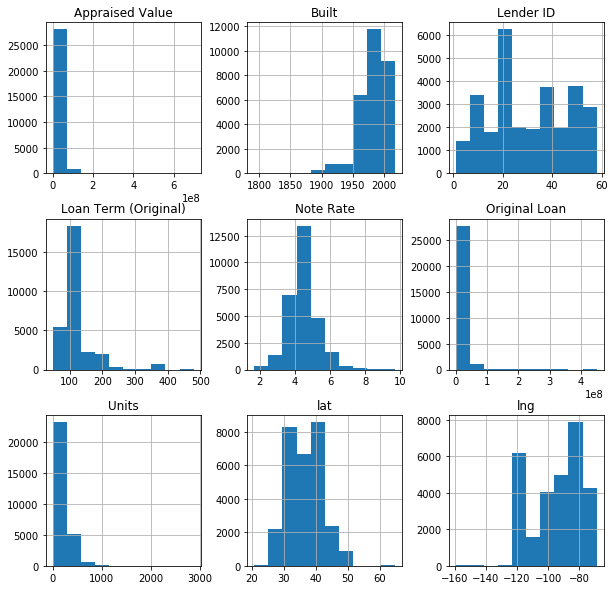

In [18]:
# Examine feature distributions (excluding binary features)
col_names = [col for col in df.columns if ('MF' not in col)]
df[col_names].hist(figsize=(10,10));

In [19]:
# Visualize correlations
def corr_plot(df, num_coln, figsize=(7,7), method='spearman', annot=False):
    
    '''
    Plot correlation coefficient matrix
    
    INPUTS:
    df (DataFrame): dataframe
    num_col (list): list of numerical column names
    
    OUTPUT:
    NONE
    '''

    # sns.set(style="white")
    corr = df[num_coln].corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(
        corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
        xticklabels=num_coln,
        yticklabels=num_coln,
        annot=annot
    )
    plt.xticks(rotation=30, ha='right', fontsize=14) 
    plt.yticks(fontsize=14);
    plt.title(f"{method.title()} Correlation Coefficient", fontsize=14)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)

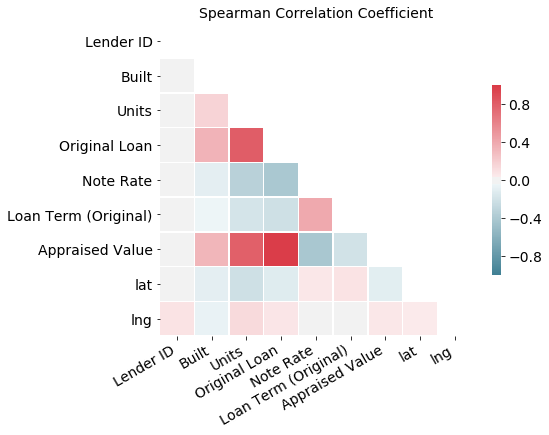

In [20]:
corr_plot(df, [col for col in df.columns if 'MF' not in col], figsize=(7,7), method='spearman', annot=False)

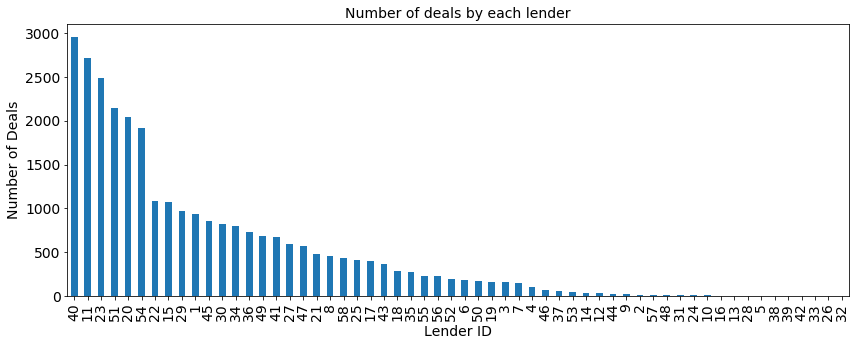

In [21]:
# Numebr of deals by each lender
plt.figure(figsize=(14,5))
df['Lender ID'].value_counts().plot.bar()
plt.title("Number of deals by each lender", fontsize=14)
plt.xlabel('Lender ID', fontsize=14)
plt.ylabel('Number of Deals', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

The classes (Lender ID) appears to be highly imbalanced.

## 3. Building a machine learning to predict lender

In [2]:
df = pd.read_csv("temp/lender_checkpoint_23.csv")
df.head()

,Lender ID,Built,Units,Original Loan,Note Rate,Loan Term (Original),Appraised Value,lat,lng,MF_Age Restricted,...,MF_MHC Age Restricted,MF_MHC Co-Op,MF_Manufactured Housing,MF_Mid Rise,MF_Military,MF_Other,MF_Senior,MF_Student,MF_Townhome,MF_Various
0,19,1990.0,24.0,1720000,5.8,180.0,3500000,33.641216,-117.918822,0,...,0,0,0,0,0,0,0,0,0,0
1,19,1962.0,15.0,500000,5.3,180.0,1525000,34.052234,-118.243685,0,...,0,0,0,0,0,0,0,0,0,0
2,50,2009.0,164.0,250000,6.9,120.0,4187586,29.951066,-90.071532,0,...,0,0,0,0,0,0,0,0,0,0
3,19,1957.0,11.0,805000,5.2,180.0,2450000,34.090009,-118.361744,0,...,0,0,0,0,0,0,0,0,0,0
4,51,2002.0,13.0,1600000,6.5,120.0,3112000,40.678178,-73.944158,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1. Train-test split

In [3]:
X = df.drop(columns=['Lender ID'])
y = df['Lender ID']

# Shuffle and split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 19517 samples.
Testing set has 9613 samples.


### 3.2. Feature scaling

Apply feature scaling to non-binary features of the training set (to avoid leaking information from the test set)

In [4]:
# Apply feature scaling to the features (excluding binary features)
to_scale = [col for col in X_train.columns if ('MF' not in col) and ('ID' not in col)]

# Rescale features
scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

# # Sanity check
# X_train[to_scale].hist(figsize=(10,10));

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [5]:
# Save the scaler for later use
scaler_filename = "temp/scaler.save"
joblib.dump(scaler, scaler_filename) 

# # And now to load...
# scaler = joblib.load(scaler_filename) 

['temp/scaler.save']

In [6]:
# Save the feature names for later use
filename = 'temp/features.pkl'
pickle.dump(X_train.columns, open(filename, 'wb'))

### 3.3. Model baseline

Because the classes are imbalanced, I'm going to use both accuracy and F-score as the metrics to evaluate model performance.

Set up a baseline model to compare machine learning results with. Here the baseline model is defined as a model that make random guesses. The machine learning model later on is expected to perform better than the baseline.

In [7]:
# Random guess based on the distribution of classes
y_proportion = y_test.value_counts() / len(y_test)
list_of_candidates = y_proportion.index.tolist()
probability_distribution = y_proportion.values.tolist()
number_of_items_to_pick = len(y_test)
y_test_pred = choice(list_of_candidates, number_of_items_to_pick,
              p=probability_distribution)

# F1 score of random guesses
f1_base = f1_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))
acc_base = accuracy_score(y_test, y_test_pred)
print(F"F1 score of baseline model (random guesses) is {round(f1_base, 4)}.")
print(F"Accuracy score of baseline model (random guesses) is {round(acc_base, 4)}.")

F1 score of baseline model (random guesses) is 0.0551.
Accuracy score of baseline model (random guesses) is 0.0552.


### 3.4. Classification model without tuning hyperparameters

Note that there are other ways to address imbalanced classes, such as oversampling and undersampling (e.g. [imbalanced-learn](http://imbalanced-learn.org/en/stable/), or sklearn [resample](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)). For the scope of this project, I'm going to proceed without exploring other options.

#### Logistic regression

In [8]:
# Logistic regression
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(clf)

# Evaluate model performance
f1_train = f1_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))
f1_test = f1_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
pd.DataFrame({'F1': [f1_train, f1_test], 'Accuracy': [acc_train, acc_test]}, index=['Training', 'Testing'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


,F1,Accuracy
Training,0.139103,0.181175
Testing,0.148498,0.183814


#### k-nearest neighbors

In [9]:
# k-nearest neighbors
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(clf)

# Evaluate model performance
f1_train = f1_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))
f1_test = f1_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
pd.DataFrame({'F1': [f1_train, f1_test], 'Accuracy': [acc_train, acc_test]}, index=['Training', 'Testing'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


,F1,Accuracy
Training,0.439440,0.445765
Testing,0.207983,0.212005


#### Random Forest

In [10]:
# Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(clf)

# Evaluate model performance
f1_train = f1_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))
f1_test = f1_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
pd.DataFrame({'F1': [f1_train, f1_test], 'Accuracy': [acc_train, acc_test]}, index=['Training', 'Testing'])

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


,F1,Accuracy
Training,0.991358,0.991341
Testing,0.218746,0.227296


The Random Forest model appears to be most powerful, although it suffers from overfitting.

#### Hyperparameter tuning

In [11]:
# Hyperparameter tuning
clf = RandomForestClassifier(random_state=42)

# Create the parameters list
parameters = {
    'n_estimators': [10, 50],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', None],
    'class_weight': ['balanced', None]
}


# Perform grid search
grid_obj = GridSearchCV(clf, parameters, scoring='accuracy', cv=3, n_jobs=2)

# Fit the grid search object
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Save the best model to disk
filename = 'temp/model_rf.pkl'
pickle.dump(best_clf, open(filename, 'wb'))

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [12]:
# Load the best model from disk
filename = 'temp/model_rf.pkl'
best_clf = pickle.load(open(filename, 'rb'))

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print(best_clf)

# Evaluate model performance
f1_train = f1_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))
f1_test = f1_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
pd.DataFrame({'F1': [f1_train, f1_test], 'Accuracy': [acc_train, acc_test]}, index=['Training', 'Testing'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


,F1,Accuracy
Training,0.999949,0.999949
Testing,0.280325,0.285343


The testing scores are higher than that of the baselibe model and the pre-tuned model, although the huge difference between training score and testing score suggests that the model should be further tuned to reduce overfitting. Given the time constraint, I'm going to keep it as it is. Future work is needed to improve the model performance.

It would also be interesting to look at confusion matrix to get a detailed understanding about model performance. For the scope of this project, I'm going to skip additional model evaluation steps.